# Fossil Submission Image Scraper
This notebook loads the CSV, downloads images per submission, and prepares for image quality analysis (BRISQUE, NIQE, VLM, etc.).

In [10]:
# Install required packages if needed
import sys
!{sys.executable} -m pip install pandas tqdm requests pillow


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\megan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
import pandas as pd
import os
import requests
from tqdm import tqdm
from urllib.parse import urlparse

# Load CSV (semicolon separated)
csv_path = '2023-01-13 Data-export Oervondstchecker (volledig; format 1)(in).csv'
df = pd.read_csv(csv_path, sep=';', encoding='latin1')
df = df.fillna('')

print(f'Total submissions: {len(df)}')

Total submissions: 19839


## Download Images Per Submission
Each submission's images will be saved in a folder named after its index and title.

output_dir = 'images_by_submission'
os.makedirs(output_dir, exist_ok=True)

def safe_folder_name(name):
    return ''.join(c if c.isalnum() or c in (' ', '_', '-') else '_' for c in name)[:40]

# Limit to first 50 submissions
for idx, row in tqdm(df.head(50).iterrows(), total=50):
    title = safe_folder_name(row['name'])
    folder = os.path.join(output_dir, f'{idx:03d}_{title}')
    os.makedirs(folder, exist_ok=True)
    image_urls = [u.strip() for u in row['images'].split(',') if u.strip() and u.lower().startswith('http')]
    downloaded = 0
    for i, url in enumerate(image_urls):
        ext = os.path.splitext(urlparse(url).path)[1] or '.jpg'
        img_path = os.path.join(folder, f'image_{i+1}{ext}')
        try:
            r = requests.get(url, timeout=10)
            if r.status_code == 200 and r.content:
                with open(img_path, 'wb') as f:
                    f.write(r.content)
                downloaded += 1
            else:
                print(f'Failed: {url} ({r.status_code})')
        except Exception as e:
            print(f'Error downloading {url}: {e}')
    print(f'Submission {idx}: Downloaded {downloaded} images to {folder}')

# Image Quality Analysis

In [12]:
import torch
import torchvision.transforms as T
from PIL import Image
import piq

# Load image
img = Image.open("images/research_grade_image.png").convert("RGB")
image_string = "images/research_grade_image.png"
# Convert to tensor in range [0,1]
transform = T.Compose([
    T.ToTensor()
])
img_tensor = transform(img).unsqueeze(0)  # shape (1, C, H, W)

# NIQE (lower is better)
#niqe_score = piq.niqe(img_tensor)
#print("NIQE score:", niqe_score.item())

# BRISQUE
brisque_score = piq.brisque(img_tensor)
print("BRISQUE score:", brisque_score.item())


BRISQUE score: 42.62762451171875


In [13]:
import cv2

img = cv2.imread(image_string, cv2.IMREAD_GRAYSCALE)
blur_score = cv2.Laplacian(img, cv2.CV_64F).var()
print("Sharpness (Laplacian variance):", blur_score)



Sharpness (Laplacian variance): 128.00807110105055


In [14]:
import cv2
import numpy as np

def brightness_contrast(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mean = np.mean(img)
    std = np.std(img)
    return mean, std

mean, std = brightness_contrast(image_string)
print("Brightness:", mean)
print("Contrast:", std)


Brightness: 209.64582665238203
Contrast: 44.32066523875555


# Check for main object (fossil)

Number of main objects detected: 2


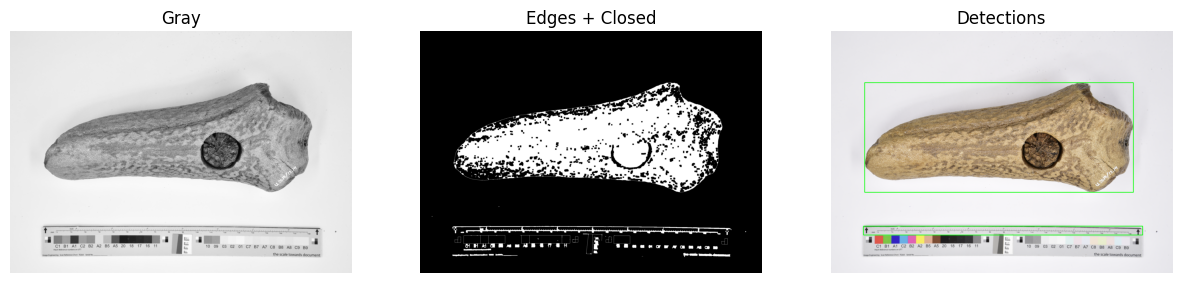

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread(image_string)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 1: Edge detection (Canny)
edges = cv2.Canny(gray, 100, 200)

# Step 2: Dilate + close edges to form solid shapes
kernel = np.ones((5,5), np.uint8)
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
closed = cv2.dilate(closed, kernel, iterations=0)

# Step 3: Find contours
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 4: Keep the largest contour(s)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
main_contours = [c for c in contours[:2]]  # fossil + maybe scale bar

print("Number of main objects detected:", len(main_contours))

# Step 5: Visualization
vis = img.copy()
for c in main_contours:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(vis, (x,y), (x+w,y+h), (0,255,0), 3)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Gray")
plt.imshow(gray, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Edges + Closed")
plt.imshow(closed, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Detections")
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()
